In [12]:
import pandas as pd
import researchpy as rp
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM
from scipy import stats
import scipy.stats.distributions as dist

In [13]:
def filter_variables(df, dict_variables) :
    inicial = True
    for key in dict_variables.keys() :
        if type(dict_variables[key]) == str:
            if inicial :
                filtro = f"({key}\'{dict_variables[key]}\')"
                inicial = False
            else:
                filtro = filtro + f" and ({key}\'{dict_variables[key]}\')"
        else:
            if inicial :
                filtro = f"({key}{dict_variables[key]})"
                inicial = False
            else:
                filtro = filtro + f" and ({key}{dict_variables[key]})"

    return pd.DataFrame(df.query(filtro))

In [14]:
data = pd.read_csv('performances.csv')
data = filter_variables(data,{
    'stage==':'Training rounds'
})
data = data.groupby(['treatment','player','round'])['accuracy'].mean().reset_index()


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2070 entries, 0 to 2069
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   treatment  2070 non-null   object 
 1   player     2070 non-null   int64  
 2   round      2070 non-null   int64  
 3   accuracy   2070 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 64.8+ KB


In [16]:
rp.summary_cont(data.groupby(['treatment'])['accuracy'])

,N,Mean,SD,SE,95% Conf.,Interval
treatment,,,,,,
dyad,979,0.9213,0.1615,0.0052,0.9112,0.9315
single,1091,0.8840,0.1908,0.0058,0.8726,0.8953


Text(0, 0.5, 'Accuracy')

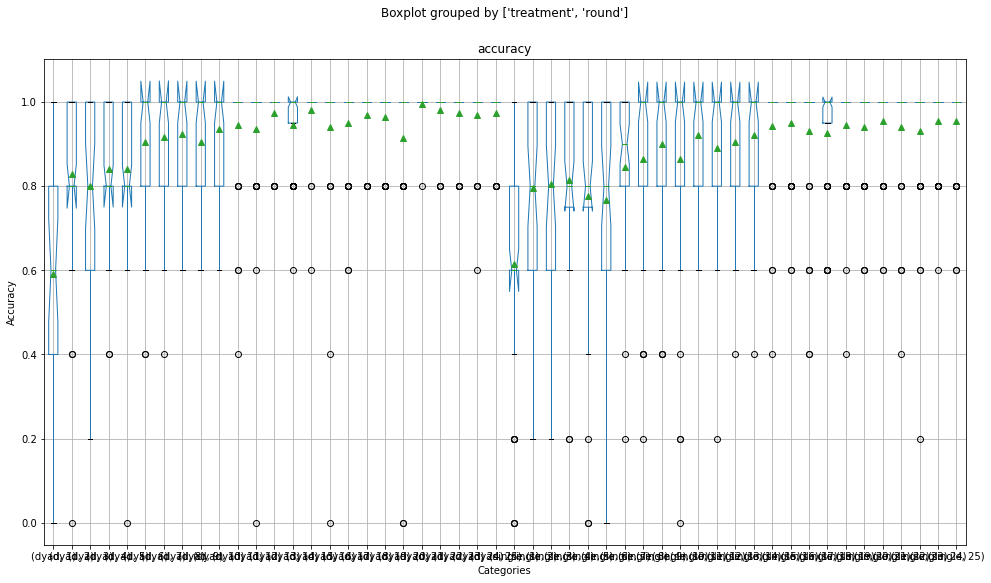

In [17]:
boxplot = data.boxplot(["accuracy"], by = ["treatment",'round'],
                     figsize = (16, 9),
                     showmeans = True,
                     notch = True)

boxplot.set_xlabel("Categories")
boxplot.set_ylabel("Accuracy")

In [33]:
model = BinomialBayesMixedGLM(
    endog=data['accuracy'],
    exog=data['treatment'],
    exog_vc=data['round'],
    ident={'0':'0 + round'}
)
result = model.fit_vb()

ValueError: ident must be a one-dimensional array

In [ ]:
model = smf.mixedlm('accuracy ~ C(treatment)',
                    data,
                    groups='round').fit()

model.summary()

In [ ]:
fig = plt.figure(figsize = (16, 9))

ax = sns.distplot(model.resid, hist = False, kde_kws = {"shade" : True, "lw": 1}, fit = stats.norm)

ax.set_title("KDE Plot of Model Residuals (Blue) and Normal Distribution (Black)")
ax.set_xlabel("Residuals")

In [ ]:
## Q-Q PLot

fig = plt.figure(figsize = (16, 9))
ax = fig.add_subplot(111)

sm.qqplot(model.resid, dist = stats.norm, line = 's', ax = ax)

ax.set_title("Q-Q Plot")

In [ ]:
labels = ["Statistic", "p-value"]

norm_res = stats.shapiro(model.resid)

for key, val in dict(zip(labels, norm_res)).items():
    print(key, val)

In [ ]:
fig = plt.figure(figsize = (16, 9))

ax = sns.scatterplot(y = model.resid, x = model.fittedvalues)

ax.set_title("RVF Plot")
ax.set_xlabel("Fitted Values")
ax.set_ylabel("Residuals")

In [ ]:
fig = plt.figure(figsize = (16, 9))

ax = sns.boxplot(x = model.model.groups, y = model.resid)

ax.set_title("Distribution of Residuals for Weight by Litter")
ax.set_ylabel("Residuals")
ax.set_xlabel("Litter")

In [ ]:
from statsmodels.stats.diagnostic import het_white

het_white_res = het_white(model.resid, model.model.exog)

labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]

for key, val in dict(zip(labels, het_white_res)).items():
    print(key, val)